## Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pip install pyPortfolioOpt
import pypfopt
from pypfopt import risk_models, expected_returns, plotting, CLA
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return

pypfopt.__version__

'1.5.6'

In [4]:
nasdaq_etf = pd.read_excel("./data/data.xlsx", skiprows=4, usecols=[0, 1], names=["Date", "NASDAQ_Returns"])
nasdaq_etf["NASDAQ_Returns"] = pd.to_numeric(nasdaq_etf["NASDAQ_Returns"], errors="coerce")
nasdaq_etf["Date"] = pd.to_datetime(nasdaq_etf["Date"], errors="coerce")
nasdaq_etf = nasdaq_etf.dropna().reset_index(drop=True)

nasdaq_etf.head()

,Date,NASDAQ_Returns
0,2010-02-28,4.540954
1,2010-03-31,7.657586
2,2010-04-30,2.159086
3,2010-05-31,-7.345586
4,2010-06-30,-6.101762


In [5]:
em_etf = pd.read_excel("./data/data.xlsx", skiprows=4, usecols=[2, 3], names=["Date", "MSCI_Returns"])
em_etf["MSCI_Returns"] = pd.to_numeric(em_etf["MSCI_Returns"], errors="coerce")
em_etf["Date"] = pd.to_datetime(em_etf["Date"], errors="coerce")
em_etf = em_etf.dropna().reset_index(drop=True)

em_etf.head()

,Date,MSCI_Returns
0,2003-05-31,8.19
1,2003-06-30,4.86
2,2003-07-31,5.93
3,2003-08-31,7.11
4,2003-09-30,0.65


In [6]:
merged_data = pd.merge(nasdaq_etf, em_etf, on="Date", how="inner")

merged_data.head()

,Date,NASDAQ_Returns,MSCI_Returns
0,2010-02-28,4.540954,0.41
1,2010-03-31,7.657586,7.93
2,2010-04-30,2.159086,0.71
3,2010-05-31,-7.345586,-9.70
4,2010-06-30,-6.101762,-0.55


In [7]:
merged_data.set_index('Date', inplace = True)

In [8]:
df = merged_data

In [9]:
df[['NASDAQ_Returns', 'MSCI_Returns']] = df[['NASDAQ_Returns', 'MSCI_Returns']] / 100
df

,NASDAQ_Returns,MSCI_Returns
Date,,
2010-02-28,0.045410,0.0041
2010-03-31,0.076576,0.0793
2010-04-30,0.021591,0.0071
2010-05-31,-0.073456,-0.0970
2010-06-30,-0.061018,-0.0055
...,...,...
2024-05-31,0.063454,0.0157
2024-06-30,0.062242,0.0310
2024-07-31,-0.016261,0.0070


In [10]:
# train test split on 2022
train_df = df[df.index < '2022-01-01']
test_df = df[df.index >= '2022-01-01']

In [11]:
# # check mu manually
# # Ensure train_df is a copy of the original DataFrame slice
# train_df = train_df.copy()

# # Extract the year and assign it to a new column
# train_df.loc[:, 'Year'] = train_df.index.year

# nasdaq_yearly_returns = train_df.groupby('Year')['NASDAQ_Returns'].apply(lambda x: (x + 1).prod() - 1)
# msci_yearly_returns = train_df.groupby('Year')['MSCI_Returns'].apply(lambda x: (x + 1).prod() - 1)

# # Calculate the mean historical yearly return for each
# mean_yearly_return_nasdaq = nasdaq_yearly_returns.mean()
# mean_yearly_return_msci = msci_yearly_returns.mean()

# # Display results
# print("NASDAQ Yearly Returns:")
# print(nasdaq_yearly_returns)
# print("\nMSCI Yearly Returns:")
# print(msci_yearly_returns)
# print(f"\nMean Historical Yearly Return (NASDAQ): {mean_yearly_return_nasdaq:.4f}")
# print(f"Mean Historical Yearly Return (MSCI): {mean_yearly_return_msci:.4f}")

In [12]:
mu = mean_historical_return(train_df, returns_data = True, frequency = 12)
S = risk_models.CovarianceShrinkage(train_df, returns_data = True, frequency = 12).ledoit_wolf()

In [13]:
mu, S

(NASDAQ_Returns    0.234380
 MSCI_Returns      0.052019
 dtype: float64,
                 NASDAQ_Returns  MSCI_Returns
 NASDAQ_Returns        0.024678      0.017052
 MSCI_Returns          0.017052      0.028701)

## Min-Variance Model

In [14]:
sample_cov = risk_models.sample_cov(train_df, returns_data=True, frequency=12)
sample_cov

,NASDAQ_Returns,MSCI_Returns
NASDAQ_Returns,0.024725,0.018396
MSCI_Returns,0.018396,0.029065


<Axes: >

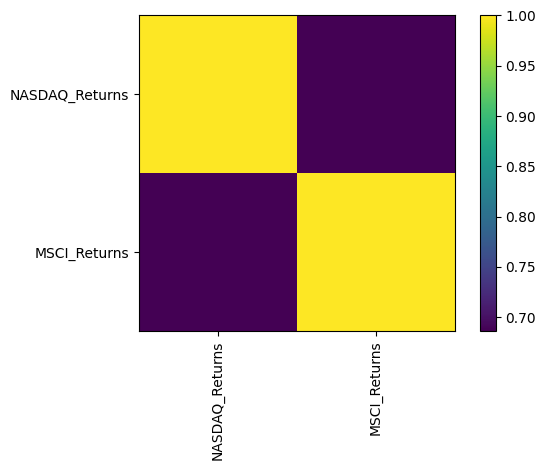

In [15]:
plotting.plot_covariance(sample_cov, plot_correlation=True)

In [16]:
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))

ef.min_volatility()
MV_weight_train = ef.clean_weights()
MV_weight_train

OrderedDict([('NASDAQ_Returns', 0.60435), ('MSCI_Returns', 0.39565)])

<Axes: >

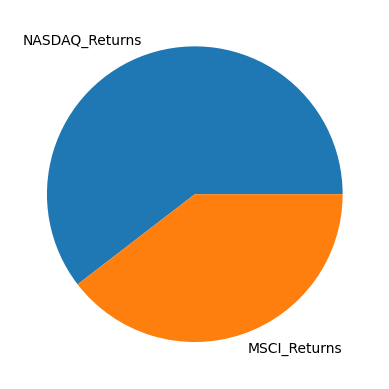

In [17]:
pd.Series(MV_weight_train).plot.pie()

In [18]:
ef.portfolio_performance(verbose= True)

Expected annual return: 16.2%
Annual volatility: 14.7%
Sharpe Ratio: 1.10


(0.16222895605602047, 0.14717659456982282, 1.1022741525593363)

## Max Sharpe Ratio Model

In [19]:
ef_sharpe = EfficientFrontier(mu, S, weight_bounds=(-1,1))
ef_sharpe.max_sharpe()
MS_weight_train = ef_sharpe.clean_weights()
MS_weight_train

OrderedDict([('NASDAQ_Returns', 1.0), ('MSCI_Returns', 0.0)])

In [20]:
ef_sharpe.portfolio_performance(verbose=True)

Expected annual return: 23.4%
Annual volatility: 15.7%
Sharpe Ratio: 1.49


(0.23438018206030664, 0.15709368558565576, 1.49197710389518)

<Axes: >

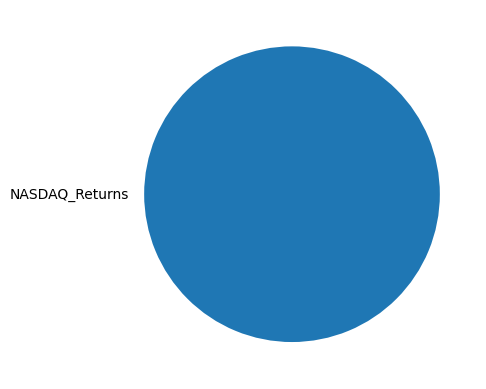

In [21]:
pd.Series(MS_weight_train).plot.pie()

## Efficient CVaR optimization

<Axes: >

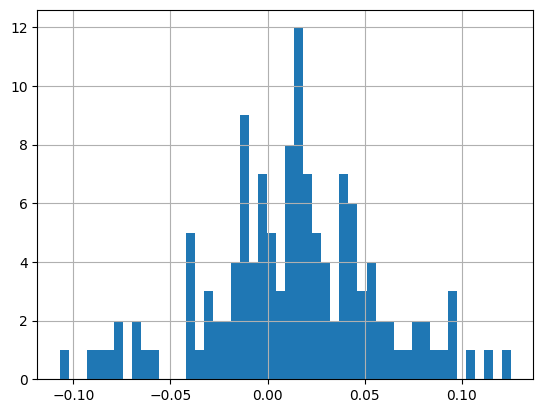

In [22]:
portfolio_rets = (train_df * MV_weight_train).sum(axis=1)
portfolio_rets.hist(bins=50)

In [23]:
# VaR
var = portfolio_rets.quantile(0.05)
cvar = portfolio_rets[portfolio_rets <= var].mean()
print("VaR: {:.2f}%".format(100*var))
print("CVaR: {:.2f}%".format(100*cvar))

VaR: -6.65%
CVaR: -8.39%


In [24]:
from pypfopt import EfficientCVaR

ec = EfficientCVaR(mu, train_df)
ec.min_cvar()
w = ec.clean_weights()
print(w)
ec.portfolio_performance(verbose=True)

OrderedDict([('NASDAQ_Returns', 1.0), ('MSCI_Returns', 0.0)])
Expected annual return: 23.4%
Conditional Value at Risk: 7.89%


(0.23438018203733582, 0.07893136062606232)

## Plotting

use the critical line algorithm.

In [25]:
# Min Var
cla = CLA(mu, S)
cla.min_volatility()
cla.portfolio_performance(verbose=True)

Expected annual return: 16.2%
Annual volatility: 14.7%
Sharpe Ratio: 1.10


(0.16222895605602045, 0.14717659456982285, 1.102274152559336)

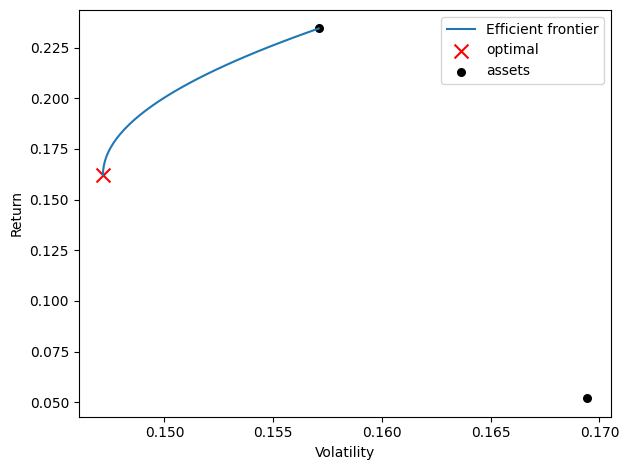

In [26]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)

In [27]:
# Max Sharpe
cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True)

Expected annual return: 23.4%
Annual volatility: 15.7%
Sharpe Ratio: 1.49


(0.23438018206030664, 0.15709368558565576, 1.49197710389518)

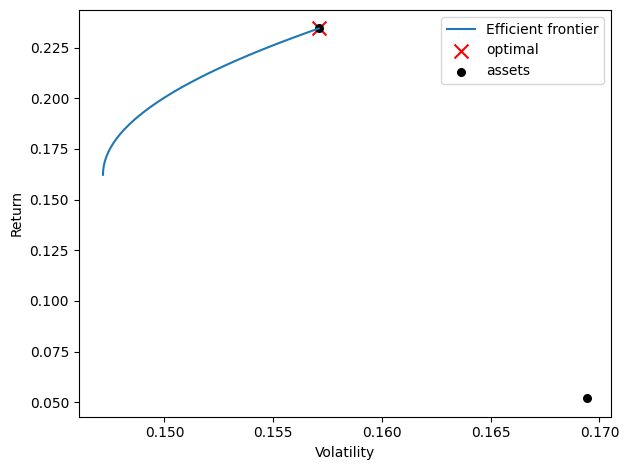

In [28]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)

In [29]:
ax = plotting.plot_efficient_frontier(cla, showfig=False, interactive=True)
ax.show()

# Test Data Performance

In [30]:
# Min-Variance Model
mu = mean_historical_return(test_df, returns_data = True, frequency = 12)
S = risk_models.CovarianceShrinkage(test_df, returns_data = True, frequency = 12).ledoit_wolf()
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))
ef.min_volatility()
MV_weight_test = ef.clean_weights()
print(MV_weight_test)
ef.portfolio_performance(verbose=True)


OrderedDict([('NASDAQ_Returns', 0.34564), ('MSCI_Returns', 0.65436)])
Expected annual return: 6.4%
Annual volatility: 16.3%
Sharpe Ratio: 0.39


(0.06356150806028586, 0.16276295158083617, 0.3905158234287614)

In [31]:
# Max-Sharpe
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))
ef.max_sharpe()
MS_weight_test = ef.clean_weights()
print(MS_weight_test)
ef.portfolio_performance(verbose=True)

OrderedDict([('NASDAQ_Returns', 1.0), ('MSCI_Returns', 0.0)])
Expected annual return: 14.4%
Annual volatility: 21.4%
Sharpe Ratio: 0.67


(0.14416628198315684, 0.21397468374249248, 0.6737539201443734)

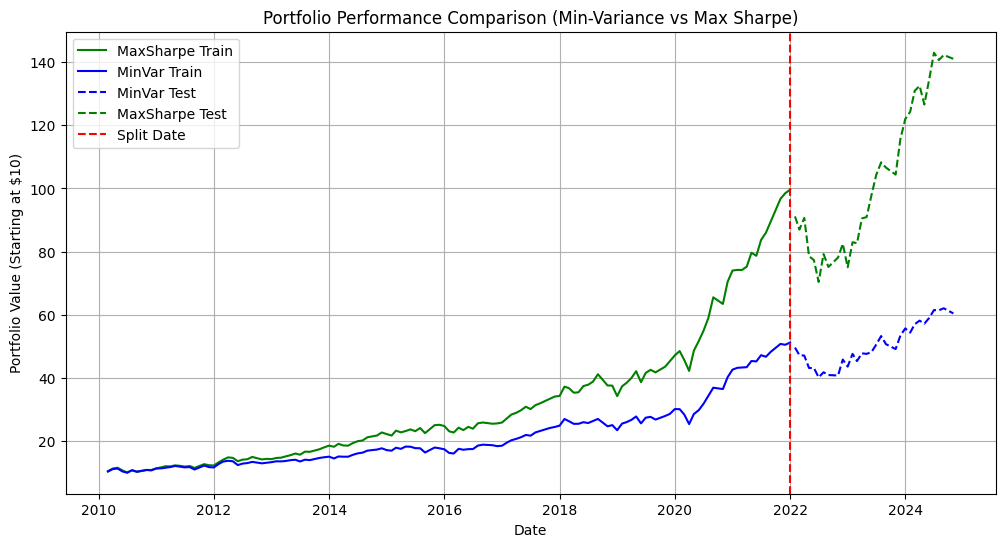

In [32]:
# Define the weights for both models in test datasets
min_var_train_weights = {'NASDAQ_Returns': MV_weight_train['NASDAQ_Returns'], 'MSCI_Returns': MV_weight_train['MSCI_Returns']}
max_sharpe_train_weights = {'NASDAQ_Returns': MS_weight_train['NASDAQ_Returns'], 'MSCI_Returns': MS_weight_train['MSCI_Returns']}

min_var_test_weights = {'NASDAQ_Returns': MV_weight_test['NASDAQ_Returns'], 'MSCI_Returns': MV_weight_test['MSCI_Returns']}
max_sharpe_test_weights = {'NASDAQ_Returns': MS_weight_test['NASDAQ_Returns'], 'MSCI_Returns': MS_weight_test['MSCI_Returns']}

# Initial investment
initial_investment = 10

# Function to compute portfolio value using returns
def compute_portfolio_value_with_returns(df, weights, initial_investment):
    # Calculate weighted portfolio returns
    portfolio_returns = (
        df['NASDAQ_Returns'] * weights['NASDAQ_Returns'] +
        df['MSCI_Returns'] * weights['MSCI_Returns']
    )
    # Compute cumulative portfolio value
    portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()
    return portfolio_value


# Calculate portfolio performance for test data
train_df_returns = train_df.copy()  # Ensure a copy of the test DataFrame
test_df_returns = test_df.copy()  # Ensure a copy of the test DataFrame

train_df_returns['MinVar_Train'] = compute_portfolio_value_with_returns(
    train_df_returns, min_var_train_weights, initial_investment)

train_df_returns['MaxSharpe_Train'] = compute_portfolio_value_with_returns(
    train_df_returns, max_sharpe_train_weights, initial_investment)

test_df_returns['MinVar_Test'] = compute_portfolio_value_with_returns(
    test_df_returns, min_var_test_weights, train_df_returns['MinVar_Train'].iloc[-1])

test_df_returns['MaxSharpe_Test'] = compute_portfolio_value_with_returns(
    test_df_returns, max_sharpe_test_weights, train_df_returns['MaxSharpe_Train'].iloc[-1])

# Plot the portfolio performance
plt.figure(figsize=(12, 6))

# Training performance
plt.plot(train_df_returns.index, train_df_returns['MaxSharpe_Train'], label='MaxSharpe Train', color='green')
plt.plot(train_df_returns.index, train_df_returns['MinVar_Train'], label='MinVar Train', color='blue')

# Testing performance
plt.plot(test_df_returns.index, test_df_returns['MinVar_Test'], label='MinVar Test', color='blue', linestyle='dashed')
plt.plot(test_df_returns.index, test_df_returns['MaxSharpe_Test'], label='MaxSharpe Test', color='green', linestyle='dashed')

# Add a vertical line for the split date
plt.axvline(pd.to_datetime('2022-01-01'), color='red', linestyle='--', label='Split Date')

# Add labels, title, and legend
plt.title('Portfolio Performance Comparison (Min-Variance vs Max Sharpe)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Starting at $10)')
plt.legend()
plt.grid()
plt.show()